### Take in the fits file and create a pupil to feed into FT_model code

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math
from math import tan, atan, hypot
# from FT_model import model_FT
# from fits_to_pupil import generate_pupil
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from radial_gradient import RWGE
# from power_region import power_ratio
# from symmetry import create_symmetry
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from PSF_analysis_functions import *

image_path = "Images/"

In [ ]:
%%time

pupils = []

# indexes = [5, 10, 15, 20]
indexes = [5]
for i in indexes:
    pupil_name = "Ben/pupil_{}.npy".format(i)
    pupil = generate_pupil(fits.open(pupil_name)[0].data)
    pupils.append(pupil)

indexes = [10, 3, 4, 8, 9]
indexes = [10]
for i in indexes:
    pupil_name = "ToliBoy_Pupil_Designs/ToliBoy_Pupil_{}.fits".format(i)
    pupil = generate_pupil(fits.open(pupil_name)[0].data)
        
    if i == 4:
        pupil = create_symmetry(pupil, 10)

    pupils.append(pupil)

In [3]:
pupils = []
for i in range(8):
    pupils.append(np.load("Ben/pupil_{}.npy".format(i)))

In [4]:
# Basic simuation settings
# aperture = 0.018                 # Aperture (m)
# aperture = 0.025                 # Aperture (m)
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-6
fl = 3.85                      # Focal length (m)
detector_pitch = 6.5e-6         # m/pixel on detector (pixel spacing)
lam = 525e-9

aperture = 0.1
m2_obsc = 0
transform_size = 2**10
q1 = 0
q2 = 0

In [5]:
# Define the radial region to analyse 
# num_fringes = 10.5
num_fringes = 10

# Image viewing extent
fringe_extent_im = 15

# Graph viewing extent
fringe_extent_graph = 15

# Horizontal line fringe values
fringe_0 = num_fringes
# fringe_1 = 6
fringe_1 = 25

# 3D plot viewing angle
elev_angle = 80
azim_angle = 30

In [6]:
# Calculate needed values
c = npixels//2
pixel_radii_0 = fl*tan(fringe_0*lam/aperture)/detector_pitch
pixel_radii_1 = fl*tan(fringe_1*lam/aperture)/detector_pitch
pixel_extent_im = int(fl*tan(2*fringe_extent_im*lam/aperture)/detector_pitch)
pixel_extent_graph = int(fl*tan(2*fringe_extent_graph*lam/aperture)/detector_pitch)
xvals = np.linspace(0, fringe_extent_im, pixel_extent_im//2)
index_0 = int(fringe_0*pixel_extent_graph/(2*fringe_extent_graph))
index_1 = int(fringe_1*pixel_extent_graph/(2*fringe_extent_graph))

In [13]:
aperture = 0.1
m2_obsc = 0
transform_size = 2**10
q1 = 0
q2 = 0

In [16]:
from lib.FT_modelling_old import *

In [18]:
%%time
outputs = []
for pupil in pupils:
    
    im_out = model_FT(pupil, aperture, npixels, wl, fl, detector_pitch)
#     im_out = FT_model(pupil, aperture, m2_obsc, npixels, wl, fl, detector_pitch, transform_size, q1, q2)
    im_out = im_out/np.sum(im_out)
        
    gradient = "{:.2f}".format(RWGE(im_out)*1e6)
    gradient_in_0 = "{:.2f}".format(RWGE(im_out, max=pixel_radii_0)*1e6)
    gradient_in_1 = "{:.2f}".format(RWGE(im_out, max=pixel_radii_1)*1e6)
    
    ratio_0 = "{:.2f}".format(power_ratio(im_out, pixel_radii_0)*100)
    ratio_1 = "{:.2f}".format(power_ratio(im_out, pixel_radii_1)*100)
    
    pixel_peak = "{:.2f}".format(np.max(im_out)*1e5)
    central = "{:.2f}".format(im_out[im_out.shape[0]//2][im_out.shape[0]//2]*1e5)
    
    evaluation = [gradient, gradient_in_0, gradient_in_1, ratio_0, ratio_1, pixel_peak, central]

    regions = np.zeros(npixels)
    peaks = np.zeros(npixels)
    cum_sum = np.zeros(npixels)
    
    for j in range(npixels):
        for k in range(npixels):
            x = j - c
            y = k - c
            r = int(hypot(x, y))
            regions[r] += im_out[j][k]
            peaks[r] = im_out[j][k] if im_out[j][k] > peaks[r] else peaks[r]
    
    for j in range(len(regions)):
        cum_sum[j] = regions[j] if j == 0 else cum_sum[j-1] + regions[j]
            
    outputs.append([pupil, im_out, evaluation, regions, peaks, cum_sum])

ValueError: could not broadcast input array from shape (1024,1024) into shape (719,719)

    _____________________________________________________________________________________________________________
    | MAXIMISE:						| MINIMISE: 						|
    _____________________________________________________________________________________________________________
    | RWGE over array:		25.28   		| Peak pixel value:	56.81 				|
    | RWGE inside 25 λ/D:	25.24			| Central pixel value:	12.66 				|
    | RWGE inside 25 λ/D:	25.24			|							|
    | % Power in 25 λ/D:	88.23			|							|
    | % Power in 25 λ/D:	88.23			|							|
    _____________________________________________________________________________________________________________



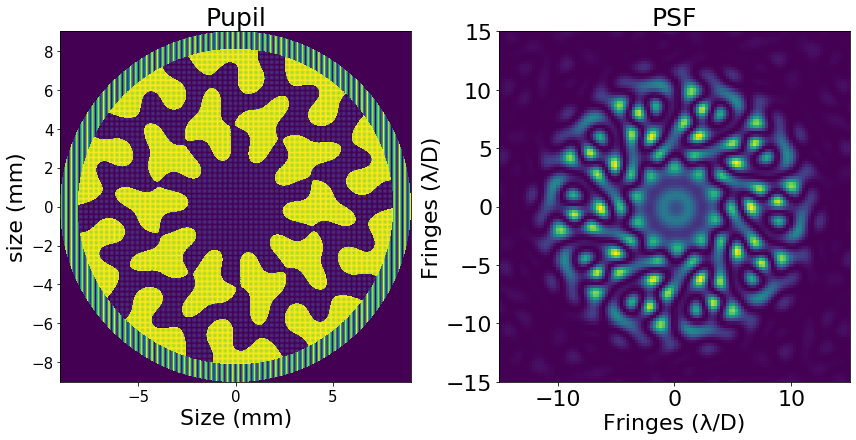

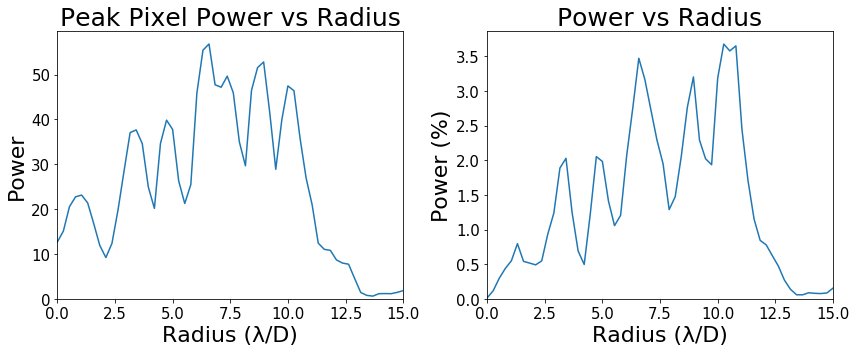

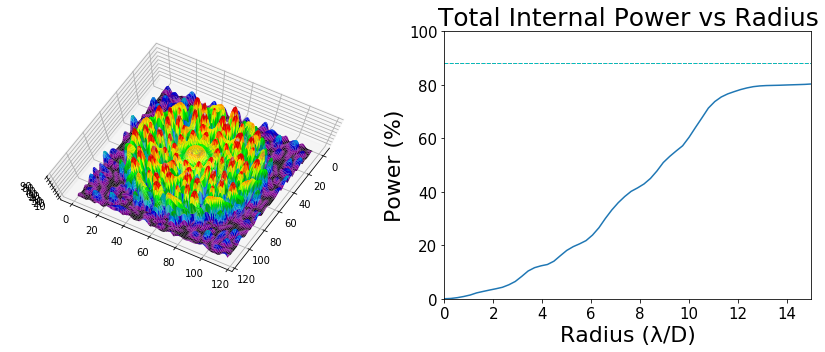

_________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________




In [28]:
for pupil_file in [outputs[0]]:
    pupil = pupil_file[0]
    im_out = pupil_file[1]
    evaluation = pupil_file[2]
    regions = pupil_file[3]
    peaks = pupil_file[4]
    cum_sum = pupil_file[5]
    
    # print Heuristiscs
    print("    _____________________________________________________________________________________________________________\n\
    | MAXIMISE:\t\t\t\t\t\t| MINIMISE: \t\t\t\t\t\t|\n\
    _____________________________________________________________________________________________________________\n\
    | RWGE over array:\t\t{2}   \t\t| Peak pixel value:\t{7} \t\t\t\t|\n\
    | RWGE inside {0} \u03BB/D:\t{3}\t\t\t| Central pixel value:\t{8} \t\t\t\t|\n\
    | RWGE inside {1} \u03BB/D:\t{4}\t\t\t|\t\t\t\t\t\t\t|\n\
    | % Power in {0} \u03BB/D:\t{5}\t\t\t|\t\t\t\t\t\t\t|\n\
    | % Power in {1} \u03BB/D:\t{6}\t\t\t|\t\t\t\t\t\t\t|\n\
    _____________________________________________________________________________________________________________\n"
    .format(fringe_0, fringe_1, evaluation[0], evaluation[1], evaluation[2], evaluation[3],\
            evaluation[4], evaluation[5], evaluation[6]))

    # First set
    ######
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    
    # First figure
    extent = -aperture*1e3/2, aperture*1e3/2, -aperture*1e3/2, aperture*1e3/2
    im = axs[0].imshow(np.abs(np.angle(pupil)/np.pi), extent=extent)
#     plt.colorbar(im, cax=make_axes_locatable(axs[0]).append_axes("right", size="5%", pad=0.05))
    axs[0].tick_params(axis='both', which='major', labelsize=15)
    axs[0].set_title("Pupil", fontsize=25)
    axs[0].set_xlabel("Size (mm)", fontsize=22)
    axs[0].set_ylabel("size (mm)", fontsize=22) 
    
    # Second figure
    extent = -fringe_extent_im, fringe_extent_im, -fringe_extent_im, fringe_extent_im
    im = axs[1].imshow(im_out[int(c-pixel_extent_im//2):int(c+pixel_extent_im//2),\
                              int(c-pixel_extent_im//2):int(c+pixel_extent_im//2)]*1e5, extent=extent)
    axs[1].tick_params(axis='both', which='major', labelsize=22)
    axs[1].set_title("PSF", fontsize=25)
    axs[1].set_xlabel("Fringes (\u03BB/D)", fontsize=22)
    axs[1].set_ylabel("Fringes (\u03BB/D)", fontsize=22) 
    axs[1].add_artist(plt.Circle((0, 0), fringe_0, color='r', fill=False))#, linewidth=0.5))
    axs[1].add_artist(plt.Circle((0, 0), fringe_1, color='c', fill=False))#, linewidth=0.5))
    
#     plt.colorbar(im, cax=make_axes_locatable(axs[1]).append_axes("right", size="5%", pad=0.05))
    plt.tight_layout()
    fig.savefig(image_path + "Pupil_PSF")
    plt.show() 
    
    # Second set
    ######
    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Third figures
    im = axs[0].plot(xvals[:pixel_extent_graph//2],peaks[:pixel_extent_graph//2]*1e5)
    axs[0].tick_params(axis='both', which='major', labelsize=15)
    axs[0].set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs[0].set_ylim(ymin=0)
    axs[0].set_title("Peak Pixel Power vs Radius", fontsize=25)
    axs[0].set_xlabel("Radius (\u03BB/D)", fontsize=22)
    axs[0].set_ylabel("Power", fontsize=22)
    axs[0].axvline(x=fringe_0, color='r', linewidth=1)
    axs[0].axvline(x=fringe_1, color='c', linewidth=1)

    # Fourth figure
    im = axs[1].plot(xvals[:pixel_extent_graph//2],regions[:pixel_extent_graph//2]*100)
    axs[1].tick_params(axis='both', which='major', labelsize=15)
    axs[1].set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs[1].set_ylim(ymin=0)
    axs[1].set_title("Power vs Radius", fontsize=25)
    axs[1].set_xlabel("Radius (\u03BB/D)", fontsize=22)
    axs[1].set_ylabel("Power (%)", fontsize=22) 
    axs[1].axvline(x=fringe_0, color='r', linewidth=1)
    axs[1].axvline(x=fringe_1, color='c', linewidth=1)

    plt.tight_layout()
    fig.savefig(image_path + "Power_distribution")
    plt.show()
    
    # Third set
    ######
    fig=plt.figure(figsize=(12,5))
    
    # Fifth Figure
    axs0 = fig.add_subplot(1,2,1,projection='3d')
    plot_3d = im_out[int(c-pixel_extent_im//2):int(c+pixel_extent_im//2),\
                     int(c-pixel_extent_im//2):int(c+pixel_extent_im//2)]*1e5
    plot_3d = ((plot_3d + 1)**0.05 - 1)*500
    xx, yy = np.mgrid[0:plot_3d.shape[0], 0:plot_3d.shape[1]]
    surf = axs0.plot_surface(xx, yy, plot_3d ,rstride=1, cstride=1, cmap=cm.nipy_spectral, linewidth=0)
    axs0.view_init(elev=elev_angle, azim=azim_angle)
    axs0.set_zlim3d(1,90)
    
    # Sixth figure
    axs1 = fig.add_subplot(1,2,2)
    im = axs1.plot(xvals[:pixel_extent_graph//2],cum_sum[:pixel_extent_graph//2]*100)
    axs1.tick_params(axis='both', which='major', labelsize=15)
    axs1.set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs1.set_ylim(ymin=0, ymax=100)
    axs1.set_title("Total Internal Power vs Radius", fontsize=25)
    axs1.set_xlabel("Radius (\u03BB/D)", fontsize=22)
    axs1.set_ylabel("Power (%)", fontsize=22)
    axs1.axvline(x=num_fringes, color='k', linewidth=1)
    axs1.axhline(y=cum_sum[index_0]*100, linestyle='--', linewidth=1, color='r')
    axs1.axhline(y=cum_sum[index_1]*100, linestyle='--', linewidth=1, color='c')
    
    plt.tight_layout()
    fig.savefig(image_path + "3d_model")
    plt.show()
    
    print("_________________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________________\n\n")

In [80]:
for pupil_file in outputs:
    pupil = pupil_file[0]
    im_out = pupil_file[1]
    evaluation = pupil_file[2]
    regions = pupil_file[3]
    peaks = pupil_file[4]
    cum_sum = pupil_file[5]

    fig, axs = plt.subplots(1, 2, figsize=(11,11))
    extent = -aperture*1e3/2, aperture*1e3/2, -aperture*1e3/2, aperture*1e3/2
    im = axs[0].imshow(np.abs(np.angle(pupil)/np.pi), extent=extent)
    plt.colorbar(im, cax=make_axes_locatable(axs[0]).append_axes("right", size="5%", pad=0.05))
    axs[0].tick_params(axis='both', which='major', labelsize=15)
    axs[0].set_title("Pupil", fontsize=25)
    axs[0].set_xlabel("Size (mm)", fontsize=22)
    axs[0].set_ylabel("size (mm)", fontsize=22) 
    
    print("    _____________________________________________________________________\n\
    | MAXIMISE:\t\t\t\t| MINIMISE: \t\t\t|\n\
    _____________________________________________________________________\n\
    | RWGE over array:\t\t{2}   | Peak pixel value:\t{7} \t|\n\
    | RWGE inside {0} \u03BB/D:\t{3}\t| Central pixel value:\t{8} \t|\n\
    | RWGE inside {1} \u03BB/D:\t{4}\t|\t\t\t\t|\n\
    | % Power in {0} \u03BB/D:\t{5}\t|\t\t\t\t|\n\
    | % Power in {1} \u03BB/D:\t\t{6}\t|\t\t\t\t|\n\
    _____________________________________________________________________\n"
    .format(fringe_0, fringe_1, evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4], evaluation[5], evaluation[6]))
    
    extent = -fringe_extent_im, fringe_extent_im, -fringe_extent_im, fringe_extent_im
    im = axs[1].imshow(im_out[int(c-pixel_extent_im//2):int(c+pixel_extent_im//2),\
                              int(c-pixel_extent_im//2):int(c+pixel_extent_im//2)]*1e5, extent=extent)
    axs[1].tick_params(axis='both', which='major', labelsize=22)
    axs[1].set_title("PSF", fontsize=25)
    axs[1].set_xlabel("Fringes (\u03BB/D)", fontsize=22)
    axs[1].set_ylabel("Fringes (\u03BB/D)", fontsize=22) 
    axs[1].add_artist(plt.Circle((0, 0), fringe_0, color='r', fill=False))#, linewidth=0.5))
    axs[1].add_artist(plt.Circle((0, 0), fringe_1, color='c', fill=False))#, linewidth=0.5))

    plt.colorbar(im, cax=make_axes_locatable(axs[1]).append_axes("right", size="5%", pad=0.05))
    plt.tight_layout()
    plt.show() 

    fig, axs = plt.subplots(1, 2, figsize=(14,3))

    im = axs[0].plot(xvals[:pixel_extent_graph//2],peaks[:pixel_extent_graph//2]*1e5)
    axs[0].tick_params(axis='both', which='major', labelsize=15)
    axs[0].set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs[0].set_ylim(ymin=0)
    axs[0].set_title("Peak Pixel Power vs Radius", fontsize=25)
    axs[0].set_xlabel("Radius (\u03BB/D)", fontsize=22)
    axs[0].set_ylabel("Power", fontsize=22)
    axs[0].axvline(x=fringe_0, color='r', linewidth=1)
    axs[0].axvline(x=fringe_1, color='c', linewidth=1)

    im = axs[1].plot(xvals[:pixel_extent_graph//2],regions[:pixel_extent_graph//2]*100)
    axs[1].tick_params(axis='both', which='major', labelsize=15)
    axs[1].set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs[1].set_ylim(ymin=0)
    axs[1].set_title("Power vs Radius", fontsize=25)
    axs[1].set_xlabel("Radius (\u03BB/D)", fontsize=22)
    axs[1].set_ylabel("Power (%)", fontsize=22) 
    axs[1].axvline(x=fringe_0, color='r', linewidth=1)
    axs[1].axvline(x=fringe_1, color='c', linewidth=1)

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(7,3))
    im = axs.plot(xvals[:pixel_extent_graph//2],cum_sum[:pixel_extent_graph//2]*100)
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs.set_ylim(ymin=0)
    axs.set_title("Total Internal Power vs Radius", fontsize=25)
    axs.set_xlabel("Radius (\u03BB/D)", fontsize=22)
    axs.set_ylabel("Power (%)", fontsize=22)
    axs.axvline(x=num_fringes, color='k', linewidth=1)
    axs.axhline(y=cum_sum[index_0]*100, linestyle='--', linewidth=1, color='r')
    axs.axhline(y=cum_sum[index_1]*100, linestyle='--', linewidth=1, color='c')
    
    plt.tight_layout()
    plt.show()
    print("______________________________________________________________________________________________________________\n\n\n\n")